# Creating an artificial brain to find the most temperamental of beasts

If you think New York is a busy place, think again.  Space is full of things continually going bump in the night!  Over its five year survey, DESI will by chance catch potentially thousands of the most tempermental of astronomical systems, including [exploding stars](https://en.wikipedia.org/wiki/Supernova), [merging neutron stars & black holes](https://en.wikipedia.org/wiki/Kilonova), 
[stars being ripped apart by black holes](https://en.wikipedia.org/wiki/Tidal_disruption_event), and other fantastic events. 

DESI scientists are smart, but even they can't identify all of these amongst > 30 million spectra.  Fortunately, they know how to create artificial brains, or neural networks, that specialize in just this task!  

<img src="images/Segev.png" alt="Drawing" style="width: 800px;"/>

In [ ]:

First, we'll focus on supernova and how we tell them apart.

### Supernova Types: Core-Collapse

In most cases, supernova are the final stage of the life cycle of very massive stars (>10 times the mass of the Sun). When the core of a massive star burns through its available nuclear fuel, it stops producing enough energy to hold up the outer envelope of the star. The star then collapses under its own weight in a fraction of a second and explodes. The remnant left behind will be a neutron star, or if the progenitor star is massive enough, a black hole. This is called a **core collapse** supernova for obvious reasons.

<img src="figures/ccsn.png" width="700px"/>

### Supernova Types: Binary System

Not all supernova occur due to a core collapse. In binary star systems made up of a compact White Dwarf and an aging main sequence star, the White Dwarf can gravitationally attract material from the envelope of its companion star. If enough material accumulates on the surface of the White Dwarf so that its total mass exceeds 1.44 solar masses (a.k.a. the [*Chandrasekhar Limit*](https://en.wikipedia.org/wiki/Chandrasekhar_limit)) then a runaway nuclear reaction occurs that blows up the White Dwarf and produces an intensely bright explosion. These are called Type Ia supernovae, and they are very important for measuring distances in cosmology.

<img src="figures/sn_ia.png" width="700px"/>

### Telling Supernovae Types Apart

Supernova types can be distinguished by looking at how their brightness changes over time (their [light curves](https://en.wikipedia.org/wiki/Light_curve)), but the most reliable method is to look at the intensity of the light as a function of wavelength -- the [spectrum](https://en.wikipedia.org/wiki/Astronomical_spectroscopy) of the supernova. Supernova spectra have distinct **very broad emission and absorption lines** produced by hot gas moving away from the explosion at high velocity. These lines provide distinct "fingerprints" that distinguish the various types. The figure below, from [a paper published in 1997](https://ned.ipac.caltech.edu/level5/March03/Filippenko/paper.pdf), shows the signature spectra of several observed supernovae.

<img src="figures/sne_filippenko.png" width="600px"/>

The flow chart below, taken from the August 2004 issue of [*Astronomy Magazine*](https://astronomy.com/magazine/2004/08/know-your-supernovae), shows how the classifications are made.

<img src="figures/supernova-matrix.GIF" width="600px"/>

## Example Spectra in the Bright Galaxy Survey

This notebook shows how supernova will appear when DESI catches them in one of the 4 million galaxies in the Brigth Galaxy Survey.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits

mpl.rc('font', size=14)

### Spectrum Plots

Here is a file containing simulated spectra from the DESI Bright Galaxy Survey (BGS). The first spectrum shows what a normal galaxy looks like. The rest show galaxies "contaminated" with light from a luminous supernova. Several types of supernova are simulated. Take a close look at the features in the spectrum and see if you can identify the difference.

In [4]:
# Open the data file and show its contents.
hdus = fits.open('data/spectrum-examples.fits')
hdus.info()

Filename: data/spectrum-examples.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  WAVE          1 PrimaryHDU       8   (6265,)   float64   
  1  FLUX          1 ImageHDU         8   (6265, 6)   float64   
  2  IVAR          1 ImageHDU         8   (6265, 6)   float64   
  3  MASK          1 ImageHDU        10   (6265, 6)   int32 (rescales to uint32)   
  4  SPECTYPE      1 BinTableHDU     11   6R x 1C   [10A]   


#### Raw Spectra

These are fluxes as they would be observed in a fiber, after we subtract known backgrounds from the night sky. They show simulated spectra from:
1. An ordinary BGS galaxy.
2. A BGS galaxy contaminated with light from a Type Ia supernova.
3. A galaxy with light from a Type Ib supernova.
4. A galaxy with light from a Type Ic supernova.
5. A galaxy with light from a Type IIn supernova.
6. A galaxy with light from a Type IIP supernova.

The spectra look different, but it's hard to see all the features.

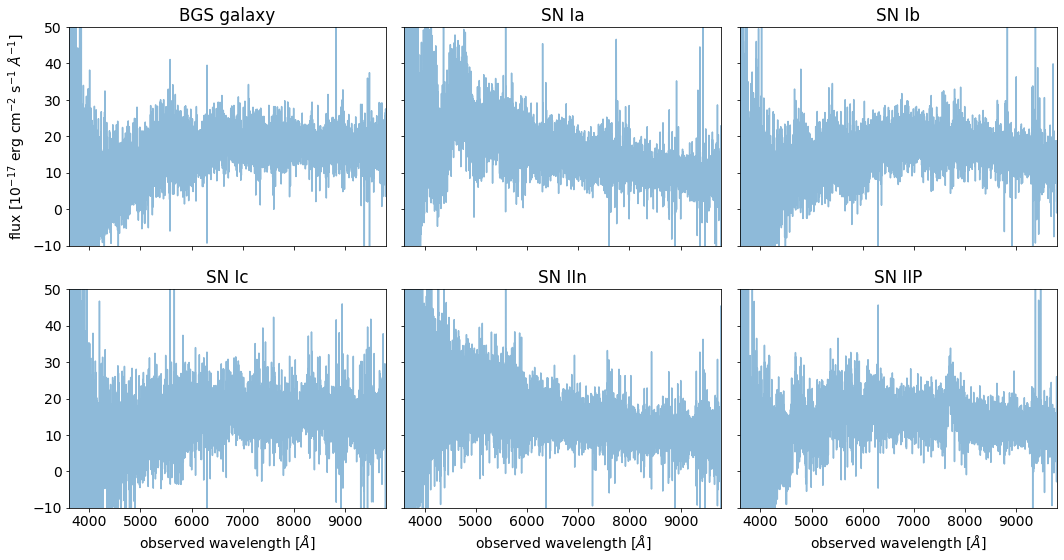

In [5]:
# Plot all the spectra on the same wavelength grid.
fig, axes = plt.subplots(2,3, figsize=(15,8), sharex=True, sharey=True, tight_layout=True)

for i, ax in enumerate(axes.flatten()):
    wave = hdus['WAVE'].data
    flux = hdus['FLUX'].data[i]
    ivar = hdus['IVAR'].data[i]
    spec = hdus['SPECTYPE'].data[i][0]
    
    ax.plot(wave, flux, alpha=0.5)
    ax.set(xlim=(3600, 9800), ylim=(-10,50),
           title=spec)

axes[0,0].set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]');
for i in range(0,3):
    axes[1,i].set(xlabel=r'observed wavelength [$\AA$]')

#### Rebinned Spectra

Rebinning means that we take the measured intensity at several wavelengths and average them together to make one new data point at a new central wavelength. This smooths out the noisy spectra and makes the broad line features of the supernovae much easier to see.

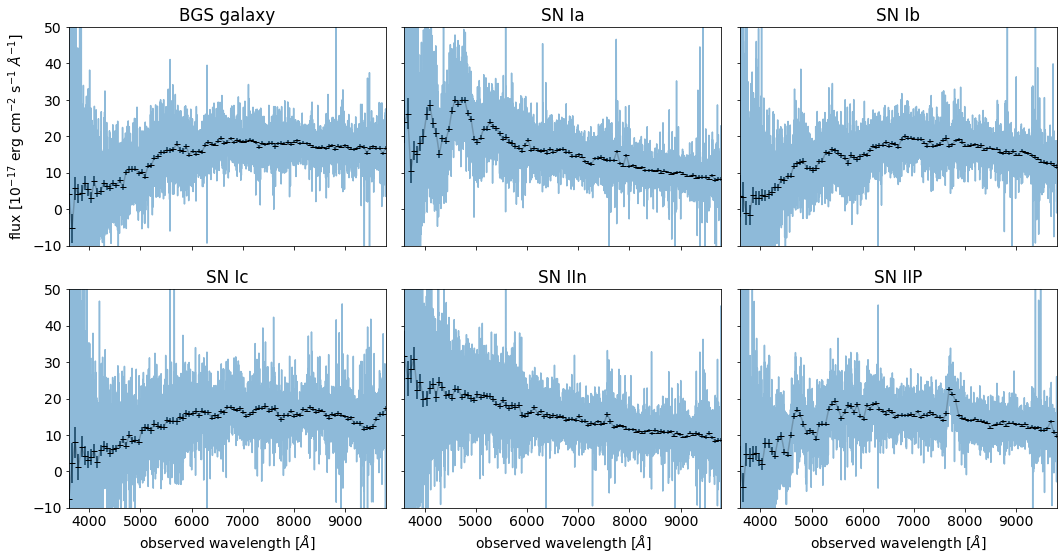

In [8]:
from desispec.interpolation import resample_flux

# Plot all the spectra on the same wavelength grid.
fig, axes = plt.subplots(2,3, figsize=(15,8), sharex=True, sharey=True, tight_layout=True)

# Resample the flux on a new wavelength grid with only 100 bins.
newwave = np.linspace(3600, 9800, 101)

for i, ax in enumerate(axes.flatten()):
    wave = hdus['WAVE'].data
    flux = hdus['FLUX'].data[i]
    ivar = hdus['IVAR'].data[i]
    spec = hdus['SPECTYPE'].data[i][0]
    
    ax.plot(wave, flux, alpha=0.5)
    
    fl, iv = resample_flux(newwave, wave, flux, ivar)
    dfl = 1./np.sqrt(iv)
    ax.plot(newwave, fl, 'k-', alpha=0.2)
    ax.errorbar(newwave, fl, yerr=dfl, fmt='k_')
    
    ax.set(xlim=(3600, 9800), ylim=(-10,50),
           title=spec)

axes[0,0].set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]');
for i in range(0,3):
    axes[1,i].set(xlabel=r'observed wavelength [$\AA$]')

## Automatically Finding Supernovae in DESI Spectra

DESI will observe so many galaxies that it will not be possible to identify supernovae or other interesting astrophysical transients such as kilonovae and tidal disruption events via manual inspection. We must do it automatically.

In a companion notebook, we will show how you can train machine-learning algorithms developed for image classification on the World Wide Web to hunt for transients in galaxy spectra.